### In this notebook we read in data needed for MARBL and generate 1D input files. 


In [ ]:
%reset

In [1]:
%matplotlib inline

import os

import cmocean
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Site to pull out from global IC / forcing files

# site_name = 'ARAB'
site_name = 'BATS'
# site_name = 'EQPAC'
# site_name = 'HOT'
# site_name = 'KERFIX'
# site_name = 'NABE'
# site_name = 'STNP'

In [3]:
cesm_in_dir='/glade/work/mlevy/cesm_inputdata/'
GRID_FILE             =  xr.open_dataset(f'{cesm_in_dir}/mom6.static.nc') # time invariant output from a CESM run on the tx0.66v1 grid
TOPO_FILE             = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/mom/tx0.66v1/ocean_topog_200701.nc') # topography for CESM run on the tx0.661v1 grid
OLD_IC_FILE           =  xr.open_dataset(f'{cesm_in_dir}/ecosys_jan_IC_omip_MOM_tx0.66v1_c221027.nc') # Combination of WOA and other fields from POP includes BGC tracers
IC_FILE               =  xr.open_mfdataset(f'{cesm_in_dir}/MOM_IC*.nc', compat='override', join='override', combine_attrs='override').isel(Time=0).drop('Time') # MOM's reported initial conditions from a CESM run on the tx0.66v1 grid

MARBL_FESEDFLUX_FILE  =  xr.open_dataset(f'{cesm_in_dir}/fesedflux_total_reduce_oxic_tx0.66v1.c211109.nc') #From Matt's notebook based on POP output; only has nlon nlat, not actual  lon/lat
MARBL_FEVENTFLUX_FILE =  xr.open_dataset(f'{cesm_in_dir}/feventflux_5gmol_tx0.66v1.c211109.nc') 

#Read in MARBL forcing from A-compset run:
MARBL_FORCING_FILE        =  xr.open_dataset('/glade/work/mlevy/codes/MOM6-examples/gen_forcing_on_tx066v1/MARBL_forcing.nc')

In [4]:
# Mask out land / layers below ocean floor, then drop fields without 'Layer' dimension
for varname in IC_FILE.data_vars:
    if 'Layer' in IC_FILE[varname].dims:
        IC_FILE[varname].data = np.where(np.isfinite(GRID_FILE['deptho'].data),
                                         IC_FILE[varname].data,
                                         np.nan)
IC_FILE = IC_FILE.drop([var for var in IC_FILE.data_vars if 'Layer' not in IC_FILE[var].dims and 'Interface' not in IC_FILE[var].dims])

In [5]:
true_lat_dict = dict()
true_lon_dict = dict()
lat_dict = dict()
lon_dict = dict()
xloc_dict = dict()
yloc_dict = dict()

lat_array = GRID_FILE['geolat'].copy()
lon_array = GRID_FILE['geolon'].copy()
# lon_array.data = np.where(lon_array.data < -200, lon_array.data+360., lon_array.data)

#print(lat_array)

#We want to extract data at a certain lat/lon point.
# BATS location is 31.666667N, 64.166667W.
true_lat_dict['BATS'] =  31.666667
true_lon_dict['BATS'] = -64.166667
# STNP location is 50N, 145W
true_lat_dict['STNP'] =  50.
true_lon_dict['STNP'] = -145.
# NABE is region bounded by 46N-48N and 17W-21W
true_lat_dict['NABE'] =  47.
true_lon_dict['NABE'] = -19.
# ARAB (S7) looks to be 15N, 62E (don't see explicit location in Smith 1998)
true_lat_dict['ARAB'] =  15.
true_lon_dict['ARAB'] = 62.
# EQPAC was conducted at 140W, presumably along equator
true_lat_dict['EQPAC'] =  0.
true_lon_dict['EQPAC'] = -140.
# HOT deep water station is 22.75 N, 158W
true_lat_dict['HOT'] =  22.75
true_lon_dict['HOT'] = -158.
# KERFIX is 50.666667S, 69.416667E
true_lat_dict['KERFIX'] =  -50.666667
true_lon_dict['KERFIX'] = 69.416667

# Find nearest point to each site on MOM grid
for site_name_loc in true_lat_dict:
    abslat = np.abs(lat_array-true_lat_dict[site_name_loc])
    abslon = np.abs(lon_array-true_lon_dict[site_name_loc])
    c = np.maximum(abslat,abslon, )

    ([yloc_dict[site_name_loc]],[xloc_dict[site_name_loc]]) = np.where(c == np.min(c))
    lon_dict[site_name_loc] = lon_array.isel(xh=xloc_dict[site_name_loc], yh=yloc_dict[site_name_loc]).data.item()
    lat_dict[site_name_loc] = lat_array.isel(xh=xloc_dict[site_name_loc], yh=yloc_dict[site_name_loc]).data.item()

# First, find the index of the grid point nearest a specific lat/lon.   
try:
    lat = lat_dict[site_name]
    lon = lon_dict[site_name]
    yloc = yloc_dict[site_name]
    xloc = xloc_dict[site_name]
except:
    raise ValueError(f'This notebook is not configured to handle {site_name} yet')

depth = TOPO_FILE['depth'].isel(ny=yloc,nx=xloc).item()
print(f'(lat, lon) is ({lat:.5f},{lon:.5f}), depth = {depth}')
print(f'(lat, lon) indices are ({yloc},{xloc})')

(lat, lon) is (31.66067,-64.01870), depth = 4549.0
(lat, lon) indices are (313,334)


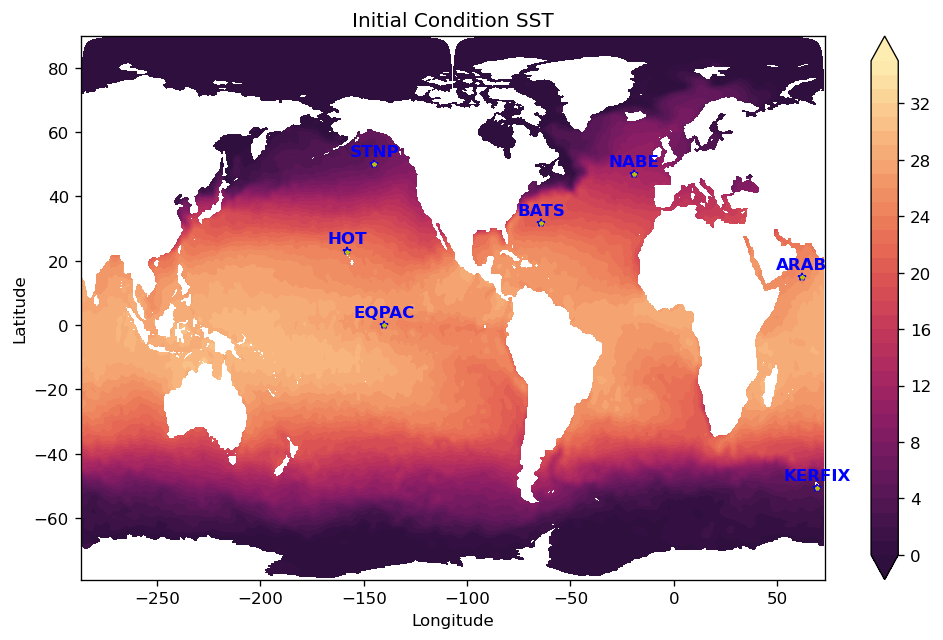

In [6]:
plt.figure(figsize=(10, 6),dpi=120)

plt.contourf(lon_array,lat_array,IC_FILE['Temp'][0,:,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=35,levels=np.linspace(0,35,36),extend='both')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Initial Condition SST')
# plt.plot(IC_FILE.LON[yloc,xloc],IC_FILE.LAT[yloc,xloc],'*r',markersize=5)
#plt.plot(TS_IC_FILE.lon[ilon_TS],TS_IC_FILE.lat[ilat_TS],'*r',markersize=8)
for site_name_loc in lat_dict.keys():
    plt.plot(lon_dict[site_name_loc],lat_dict[site_name_loc],'*b',markersize=5) # Blue is actual location of site
    plt.plot(true_lon_dict[site_name_loc],true_lat_dict[site_name_loc],'*y',markersize=2.5) # Yellow is nearest CESM-MOM grid cell center
    plt.text(lon_dict[site_name_loc],lat_dict[site_name_loc]+2.5,site_name_loc,color='b',horizontalalignment='center',fontweight='semibold')

plt.show()

In [7]:
def set_fill_value(ds):
    '''
    No _FillValue attribute for coordinates, -1e34 for data variables
    '''
    for var in ds.coords:
        ds[var].encoding['_FillValue'] = None
        if 'missing_value' in ds[var].encoding:
            del ds[var].encoding['missing_value']

    for var in ds.data_vars:
        if ds[var].data.dtype in ['float32', 'float64']:
            ds[var].encoding['_FillValue'] = -1.e34
        if 'missing_value' in ds[var].encoding:
            del ds[var].encoding['missing_value']

    return ds

In [8]:
IC_FILE_COLUMN               = IC_FILE.isel(lath=[yloc-1,yloc], lonh=[xloc-1,xloc])
TOPO_FILE_COLUMN             = TOPO_FILE.isel(ny=[yloc-1,yloc], nx=[xloc-1,xloc])
MARBL_FESEDFLUX_FILE_COLUMN  = MARBL_FESEDFLUX_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})
MARBL_FEVENTFLUX_FILE_COLUMN = MARBL_FEVENTFLUX_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])  #leaving braces around [xloc] and [yloc] preserves that dimension

# TS_IC_FILE_COLUMN            = TS_IC_FILE.isel(lat=[ilat_TS-1,ilat_TS],lon=[ilon_TS-1,ilon_TS])

MARBL_FORCING_temp    = MARBL_FORCING_FILE.isel(nlat=[yloc-1,yloc], nlon=[xloc-1,xloc])
#MARBL_FORCING_temp    = MARBL_FORCING_FILE.isel(time = np.arange(0,365), nlat=[yloc-1,yloc], nlon=[xloc-1,xloc])


print(MARBL_FORCING_temp.lat[:,0])
print(MARBL_FORCING_temp.lon[0,:])

#Making some modifications to MARBL_FORCING_FILE_COLUMN:
ds = MARBL_FORCING_temp

ds = ds.rename_dims({'nlat': 'gridlat_t', 'nlon': 'gridlon_t'})
ds = ds.assign_coords({'gridlat_t': MARBL_FORCING_temp.lat[:,0], 'gridlon_t': MARBL_FORCING_temp.lon[0,:]})
ds.gridlat_t.attrs['units'] = 'degree_north'
ds.gridlat_t.attrs['cartesian_axis'] = 'Y'
ds.gridlon_t.attrs['units'] = 'degree_east'
ds.gridlon_t.attrs['cartesian_axis'] = 'X'

#ds.time.encoding['_FillValue'] = 10000000000. 
ds.time.attrs['units'] = "days since 1982-01-01 00:00:00"
ds.time.attrs['time_origin'] = "01-JAN-1982 00:00:00"
ds.time.attrs['calendar'] = 'NOLEAP'
ds.time.attrs['cartesian_axis'] = 'T'
ds.time.attrs['modulo'] = " "
ds.time.attrs['modulo_beg'] = "1982-01-01 00:00:00"
ds.time.attrs['modulo_end'] = "1987-01-01 00:00:00"


ds.gridlon_t.encoding['_FillValue'] = None
ds.gridlat_t.encoding['_FillValue'] = None

MARBL_FORCING_FILE_COLUMN = ds;



<xarray.DataArray 'lat' (nlat: 2)>
array([31.099484, 31.657515])
Coordinates:
    lat      (nlat) float64 ...
    lon      (nlat) float64 ...
Dimensions without coordinates: nlat
Attributes:
    units:    degrees_north
<xarray.DataArray 'lon' (nlon: 2)>
array([-64.682013, -64.015321])
Coordinates:
    lat      (nlon) float64 ...
    lon      (nlon) float64 ...
Dimensions without coordinates: nlon
Attributes:
    units:    degrees_east


In [9]:
#Setting 4 points on the grid to be equal to the first point
def set_all_equal(da, third_dim_names='DEPTH'):
    print(f'Making sure {da.name} values are identical in every column')
    if type(third_dim_names) == str:
        third_dim_names = [third_dim_names]
    is_3d = any([third_dim_name in da.dims for third_dim_name in third_dim_names])
    if is_3d:
        da.data[:,1,0] = da.data[:,0,0]
        da[:,0,1] = da.data[:,0,0]
        da[:,1,1] = da.data[:,0,0]
    else:
        da.data[1,0] = da.data[0,0]
        da.data[0,1] = da.data[0,0]
        da.data[1,1] = da.data[0,0]
    return da

In [10]:
# Also update Layer dimension for IC_FILE_COLUMN
for field in IC_FILE_COLUMN.data_vars:
    IC_FILE_COLUMN[field] = set_all_equal(IC_FILE_COLUMN[field], ['Layer', 'Interface'])
# Compute depth variable for IC_FILE_COLUMN
# assign coordinates to match DataSet
depth = -0.5*(IC_FILE_COLUMN.eta[:-1,:,:].rename(Interface='Layer').assign_coords(Layer=IC_FILE_COLUMN['Layer'].values) +
              IC_FILE_COLUMN.eta[1:,:,:].rename(Interface='Layer').assign_coords(Layer=IC_FILE_COLUMN['Layer'].values)).rename('depth')
IC_FILE_COLUMN = IC_FILE_COLUMN.assign_coords({'Layer': depth.isel(lath=0,lonh=0).values})
IC_drop_vars = ['h', 'u', 'v', 'u2', 'v2', 'CAu', 'CAv', 'diffu', 'diffv', 'age', 'Kd_shear', 'Kv_shear', 'MARBL_PH_3D', 'MARBL_PH_3D_ALT_CO2']
for var in IC_drop_vars:
    IC_FILE_COLUMN = IC_FILE_COLUMN.drop(var)

print('----')

for field in TOPO_FILE_COLUMN.data_vars:
    TOPO_FILE_COLUMN[field] = set_all_equal(TOPO_FILE_COLUMN[field])
TOPO_FILE_COLUMN = set_fill_value(TOPO_FILE_COLUMN)

print('----')

for field in MARBL_FESEDFLUX_FILE_COLUMN.data_vars:
    MARBL_FESEDFLUX_FILE_COLUMN[field] = set_all_equal(MARBL_FESEDFLUX_FILE_COLUMN[field])
MARBL_FESEDFLUX_FILE_COLUMN = set_fill_value(MARBL_FESEDFLUX_FILE_COLUMN)

print('----')

for field in MARBL_FEVENTFLUX_FILE_COLUMN.data_vars:
    MARBL_FEVENTFLUX_FILE_COLUMN[field] = set_all_equal(MARBL_FEVENTFLUX_FILE_COLUMN[field])
MARBL_FEVENTFLUX_FILE_COLUMN = set_fill_value(MARBL_FEVENTFLUX_FILE_COLUMN)

print('----')

for field in MARBL_FORCING_FILE_COLUMN.data_vars:
    MARBL_FORCING_FILE_COLUMN[field] = set_all_equal(MARBL_FORCING_FILE_COLUMN[field], 'time')
MARBL_FORCING_FILE_COLUMN = set_fill_value(MARBL_FORCING_FILE_COLUMN)

Making sure Temp values are identical in every column
Making sure Salt values are identical in every column
Making sure h values are identical in every column
Making sure u values are identical in every column
Making sure v values are identical in every column
Making sure u2 values are identical in every column
Making sure v2 values are identical in every column
Making sure CAu values are identical in every column
Making sure CAv values are identical in every column
Making sure diffu values are identical in every column
Making sure diffv values are identical in every column
Making sure age values are identical in every column
Making sure PO4 values are identical in every column
Making sure NO3 values are identical in every column
Making sure SiO3 values are identical in every column
Making sure NH4 values are identical in every column
Making sure Fe values are identical in every column
Making sure Lig values are identical in every column
Making sure O2 values are identical in every col

In [11]:
# Set attributes in MARBL_FORCING_FILE_COLUMN for files that violate typical MOM6 sign convention
# (most fluxes are positive into the ocean, but MOM6 expects evaporation and sensible heat flux to be positive up)
MARBL_FORCING_FILE_COLUMN['SENS_HEAT_FLUX'].data = -MARBL_FORCING_FILE_COLUMN['SENS_HEAT_FLUX'].data
MARBL_FORCING_FILE_COLUMN['SENS_HEAT_FLUX'].attrs['standard_name'] = 'surface_upward_sensible_heat_flux'
MARBL_FORCING_FILE_COLUMN['EVAP'].data = -MARBL_FORCING_FILE_COLUMN['EVAP'].data
MARBL_FORCING_FILE_COLUMN['EVAP'].attrs['standard_name'] = 'surface_upward_latent_heat_flux_due_to_evaporation'

In [12]:
##Modifications so that we use Kristen's 4p2z model:
print(IC_FILE_COLUMN)

IC_FILE_COLUMN = IC_FILE_COLUMN.rename({'lath': 'lat', 'lonh': 'lon'})

IC_FILE_COLUMN['coccoC'] = IC_FILE_COLUMN['spC'] * 0.07
IC_FILE_COLUMN['coccoFe'] = IC_FILE_COLUMN['spFe'] * 0.07
IC_FILE_COLUMN['coccoP'] = IC_FILE_COLUMN['spP'] * 0.07
IC_FILE_COLUMN['coccoChl'] = IC_FILE_COLUMN['spChl'] * 0.07

# and then reduce the sp pools so biomass is conserved:
IC_FILE_COLUMN['spC'] = IC_FILE_COLUMN['spC'] * 0.93
IC_FILE_COLUMN['spFe'] = IC_FILE_COLUMN['spFe'] * 0.93
IC_FILE_COLUMN['spP'] = IC_FILE_COLUMN['spP'] * 0.93
IC_FILE_COLUMN['spChl'] = IC_FILE_COLUMN['spChl'] * 0.93

#For coccoCaCO3, just set that equal to spCaCO3:
IC_FILE_COLUMN['coccoCaCO3'] = IC_FILE_COLUMN['spCaCO3']
#and then drop spCaCO3 (it's not a tracer in Kristen's 4p2z version of MARBL)
IC_FILE_COLUMN = IC_FILE_COLUMN.drop(['spCaCO3'])

IC_FILE_COLUMN['mesozooC'] = IC_FILE_COLUMN['zooC'] * 0.56
IC_FILE_COLUMN['microzooC'] = IC_FILE_COLUMN['zooC'] * 0.44
#and then drop zooC:
IC_FILE_COLUMN = IC_FILE_COLUMN.drop(['zooC'])

IC_FILE_COLUMN = set_fill_value(IC_FILE_COLUMN)
print(IC_FILE_COLUMN)

<xarray.Dataset>
Dimensions:      (lath: 2, lonh: 2, latq: 458, lonq: 540, Layer: 65,
                  Interface: 66)
Coordinates:
  * lath         (lath) float64 31.18 31.75
  * lonh         (lonh) float64 -64.67 -64.0
  * latq         (latq) float64 -79.14 -79.01 -78.89 ... 87.68 87.73 87.74
  * lonq         (lonq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.67 72.33 73.0
  * Layer        (Layer) float64 1.25 3.75 6.25 ... 4.523e+03 4.523e+03
  * Interface    (Interface) float64 0.0 2.5 5.0 ... 5.503e+03 5.751e+03 6e+03
Data variables: (12/35)
    Temp         (Layer, lath, lonh) float64 dask.array<chunksize=(65, 2, 2), meta=np.ndarray>
    Salt         (Layer, lath, lonh) float64 dask.array<chunksize=(65, 2, 2), meta=np.ndarray>
    PO4          (Layer, lath, lonh) float64 dask.array<chunksize=(65, 2, 2), meta=np.ndarray>
    NO3          (Layer, lath, lonh) float64 dask.array<chunksize=(65, 2, 2), meta=np.ndarray>
    SiO3         (Layer, lath, lonh) float64 dask.array<chunksize=(6

In [13]:
keys = [key for key in IC_FILE_COLUMN.keys() if 'Layer' in IC_FILE_COLUMN[key].dims]
len(keys)

39

In [14]:
keys

['Temp',
 'Salt',
 'PO4',
 'NO3',
 'SiO3',
 'NH4',
 'Fe',
 'Lig',
 'O2',
 'DIC',
 'DIC_ALT_CO2',
 'ALK',
 'ALK_ALT_CO2',
 'DOC',
 'DON',
 'DOP',
 'DOPr',
 'DONr',
 'DOCr',
 'spChl',
 'spC',
 'spP',
 'spFe',
 'diatChl',
 'diatC',
 'diatP',
 'diatFe',
 'diatSi',
 'diazChl',
 'diazC',
 'diazP',
 'diazFe',
 'coccoC',
 'coccoFe',
 'coccoP',
 'coccoChl',
 'coccoCaCO3',
 'mesozooC',
 'microzooC']

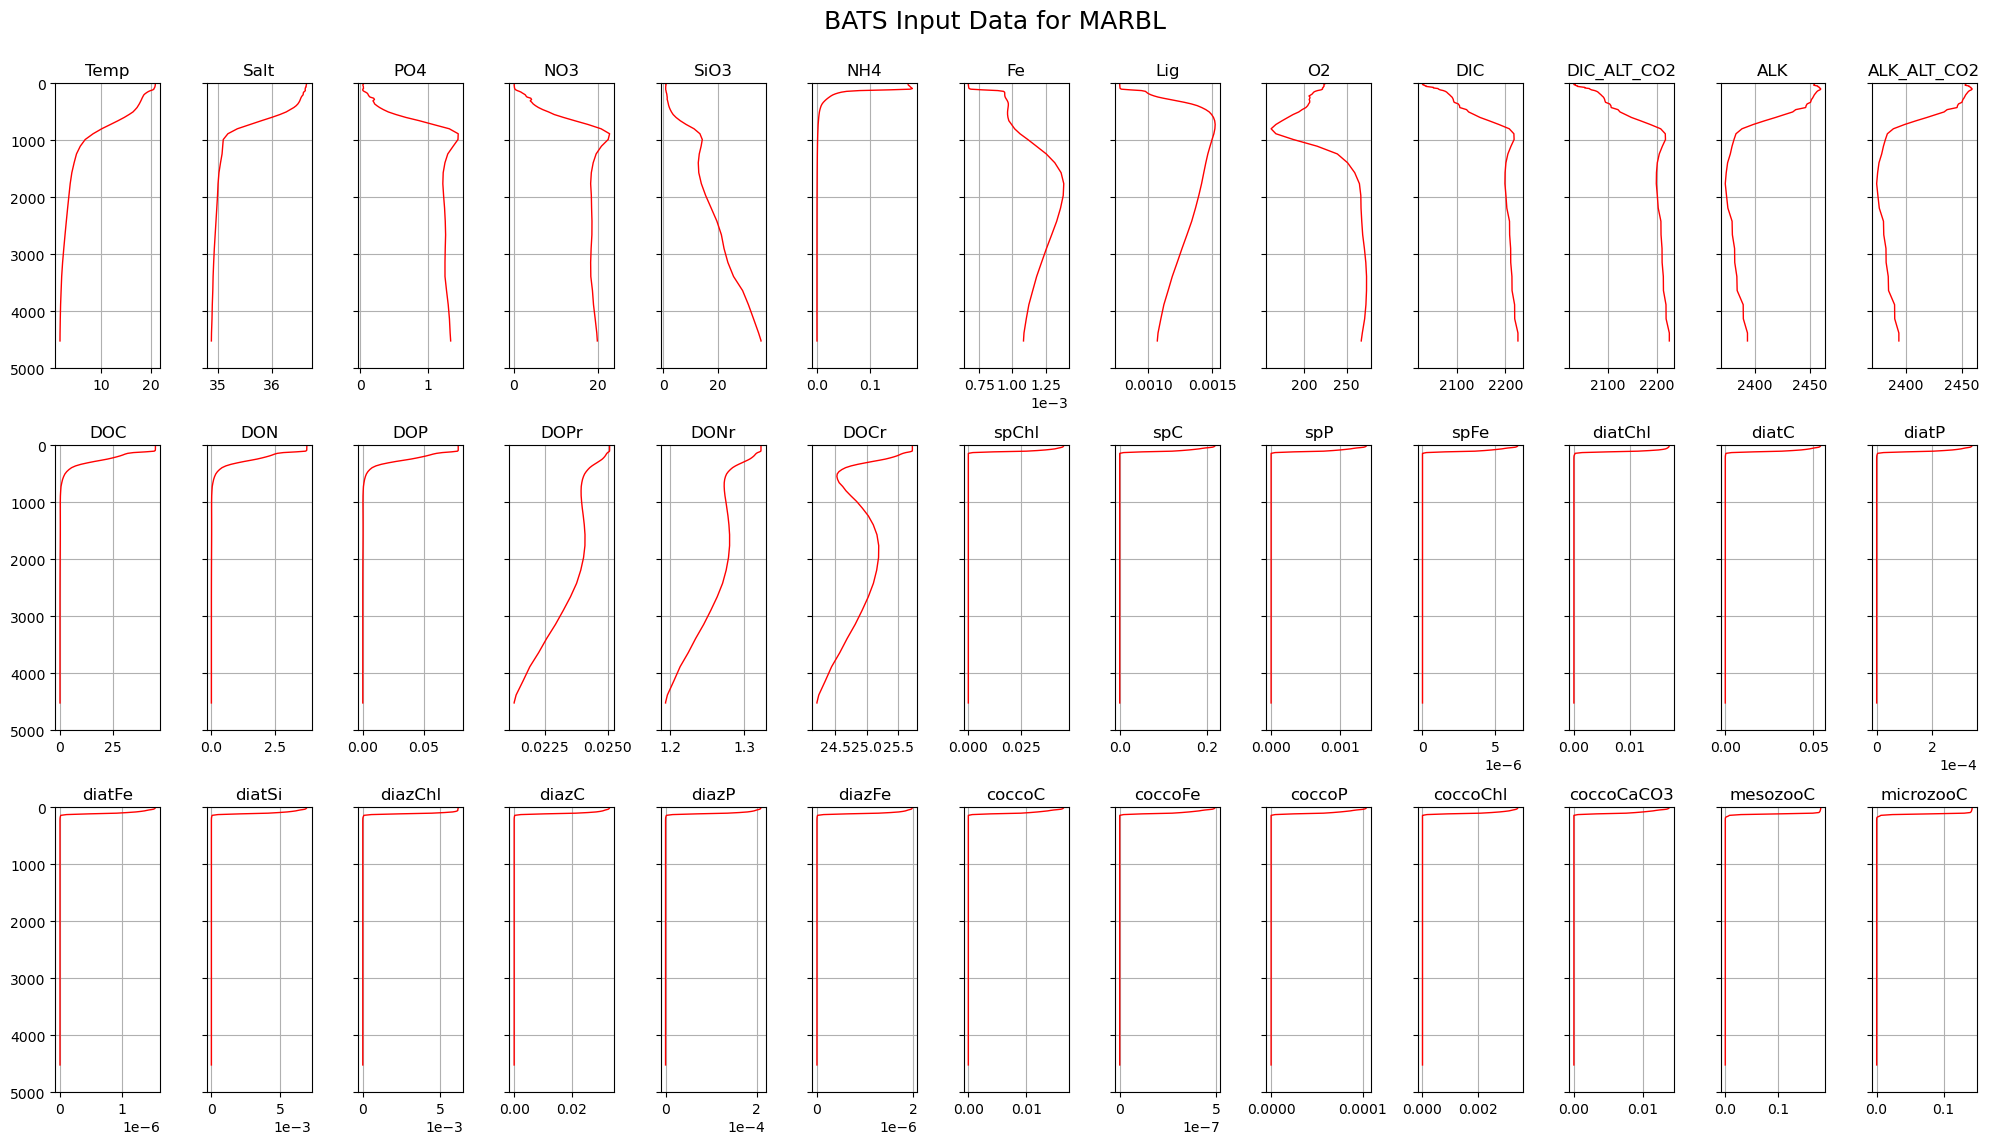

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=13, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle(f"{site_name} Input Data for MARBL", fontsize=18, y=0.95)
ymax = 500* (1 + TOPO_FILE_COLUMN['depth'].isel(nx=0,ny=0).values.item() // 500)
for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.Layer,'r',linewidth=1)

    ax.set_ylim([ymax, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe','coccoFe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#fig.delaxes(axs[-1][-1])
#fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])


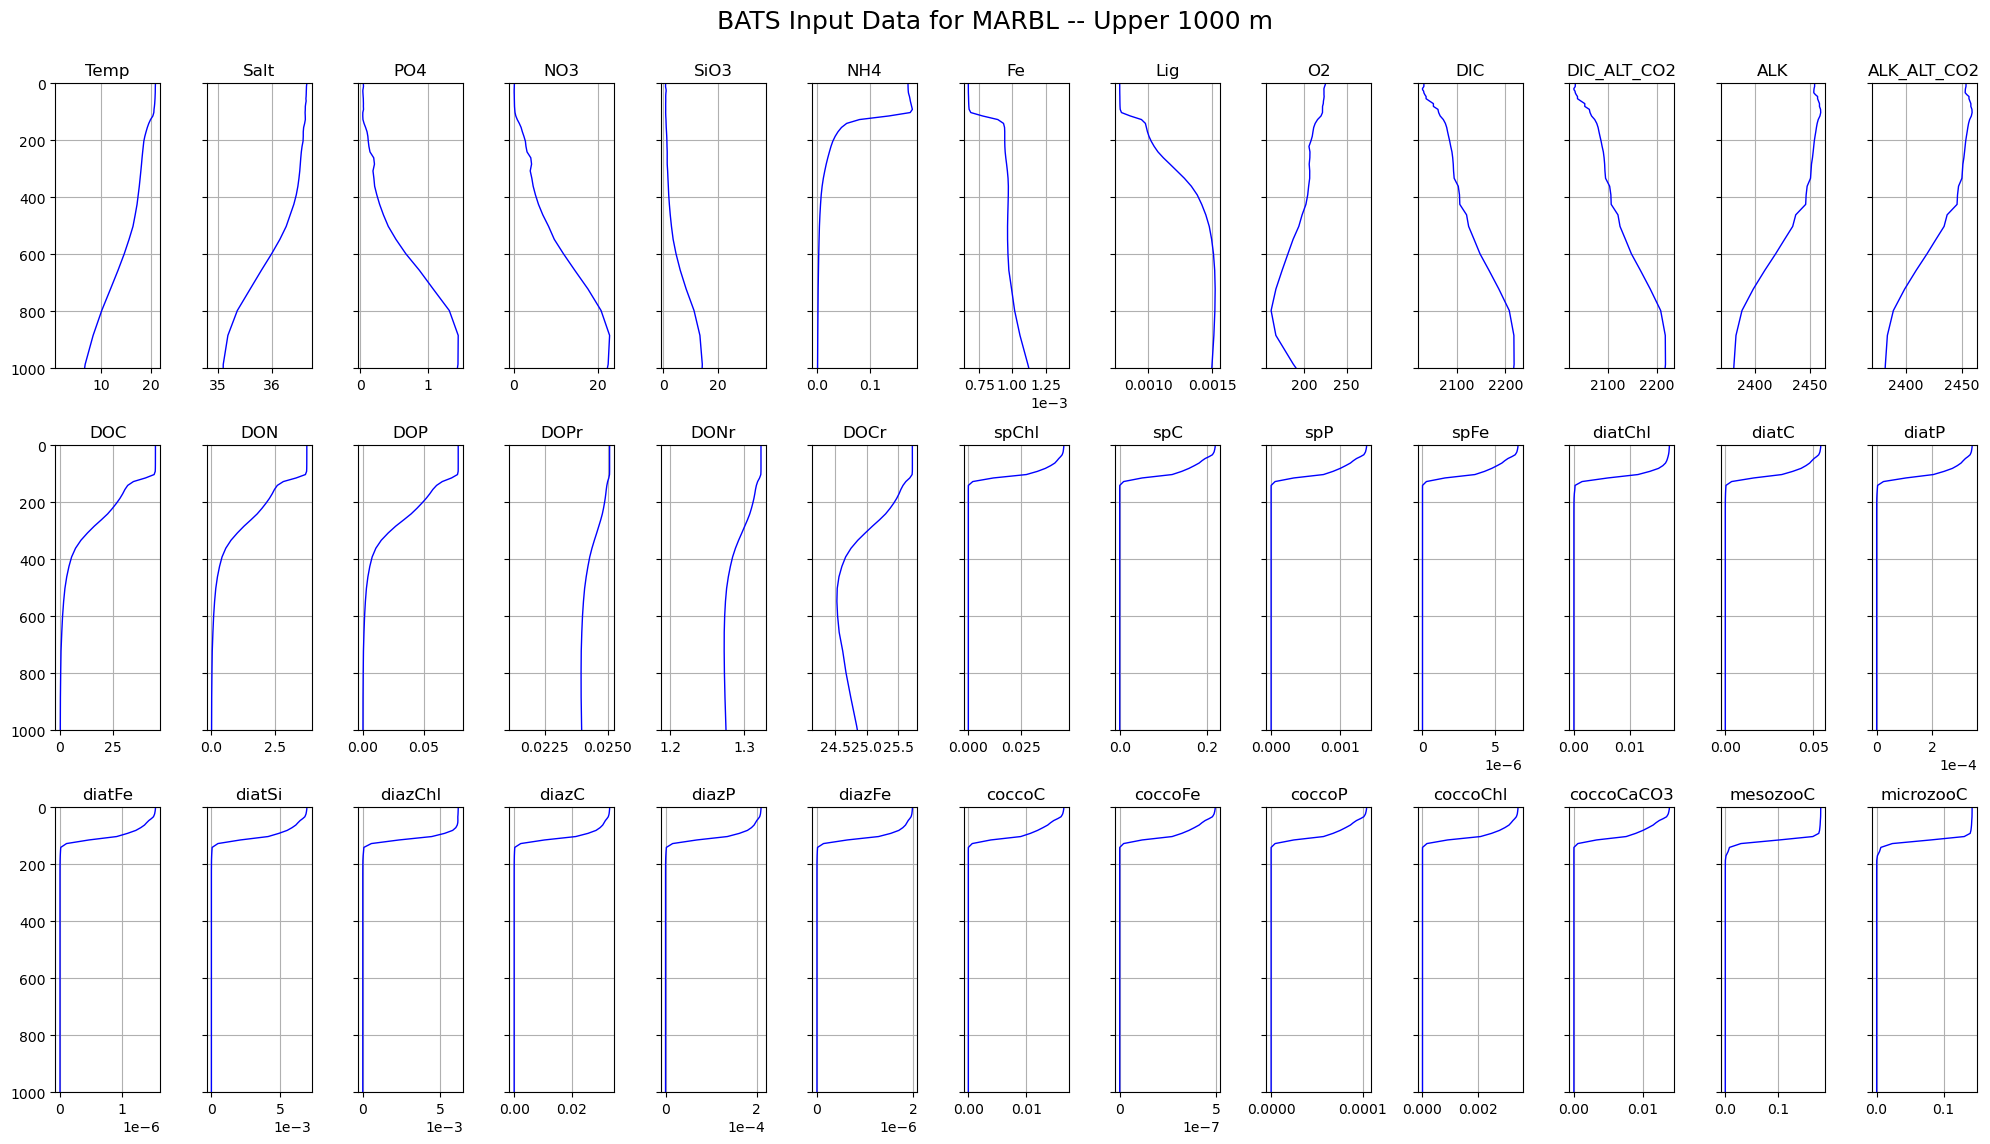

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=13, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle(f"{site_name} Input Data for MARBL -- Upper 1000 m", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.Layer,'b',linewidth=1)

    ax.set_ylim([1000, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe','coccoFe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#fig.delaxes(axs[-1][-1])
#fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])

## Adding SST and SSS restoring to the MARBL_FORCING_FILE_COLUMN:

In [17]:
initial_salt = np.nanmean(IC_FILE_COLUMN.Salt[0,:])
initial_temp = np.nanmean(IC_FILE_COLUMN.Temp[0,:])
print(initial_salt, initial_temp)

36.655915287901344 20.867275743831517


In [18]:
MARBL_FORCING_FILE_COLUMN['SST_RESTORE'] = xr.zeros_like(MARBL_FORCING_FILE_COLUMN.SWDN)+initial_temp
MARBL_FORCING_FILE_COLUMN['SST_RESTORE'].attrs = MARBL_FORCING_FILE_COLUMN.SWDN.attrs
MARBL_FORCING_FILE_COLUMN['SST_RESTORE'].attrs['units'] = IC_FILE_COLUMN.Temp.attrs['units']
MARBL_FORCING_FILE_COLUMN['SST_RESTORE'].encoding = IC_FILE_COLUMN.Temp.encoding
MARBL_FORCING_FILE_COLUMN['SSS_RESTORE'] = xr.zeros_like(MARBL_FORCING_FILE_COLUMN.SWDN)+initial_salt
MARBL_FORCING_FILE_COLUMN['SSS_RESTORE'].attrs = MARBL_FORCING_FILE_COLUMN.SWDN.attrs
MARBL_FORCING_FILE_COLUMN['SSS_RESTORE'].attrs['units'] = IC_FILE_COLUMN.Salt.attrs['units']
MARBL_FORCING_FILE_COLUMN['SSS_RESTORE'].encoding = IC_FILE_COLUMN.Salt.encoding

MARBL_FORCING_FILE_COLUMN

<xarray.Dataset>
Dimensions:               (time: 1825, gridlat_t: 2, gridlon_t: 2, nlat: 2,
                           nlon: 2)
Coordinates:
  * time                  (time) float64 0.5 1.5 2.5 ... 1.824e+03 1.824e+03
    lat                   (gridlat_t, gridlon_t) float64 ...
    lon                   (gridlat_t, gridlon_t) float64 ...
    gridlat_t             (nlat) float64 ...
    gridlon_t             (nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables: (12/19)
    ATM_FINE_DUST_FLUX    (time, gridlat_t, gridlon_t) float64 5.759e-14 ... ...
    ATM_COARSE_DUST_FLUX  (time, gridlat_t, gridlon_t) float64 1.86e-12 ... 1...
    ATM_BC_FLUX           (time, gridlat_t, gridlon_t) float64 1.22e-13 ... 1...
    SEAICE_DUST_FLUX      (time, gridlat_t, gridlon_t) float64 0.0 0.0 ... 0.0
    SEAICE_BC_FLUX        (time, gridlat_t, gridlon_t) float64 0.0 0.0 ... 0.0
    U10_SQR               (time, gridlat_t, gridlon_t) float64 22.03 ... 269.5
    ...                    ...
    SENS_HEAT_FLUX        (time, gridlat_t, gridlon_t) float64 2.443 ... 182.9
    TAUX                  (time, gridlat_t, gridlon_t) float64 -0.02375 ... 0...
    TAUY                  (time, gridlat_t, gridlon_t) float64 0.001864 ... -...
    SNOW                  (time, gridlat_t, gridlon_t) float64 0.0 0.0 ... 0.0
    SST_RESTORE           (time, gridlat_t, gridlon_t) float64 20.87 ... 20.87
    SSS_RESTORE           (time, gridlat_t, gridlon_t) float64 36.66 ... 36.66

## Finally save the MARBL column input files within the proper input directory in single_column_MARBL example directory

Also write `MOM_override`

In [19]:
#%cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/INPUT/BATS/
USER = os.environ['USER']
if  USER == 'eyankovsky':
    out_dir = f'/glade/u/home/eyankovsky/CESM/cesm2_3_alpha12b+mom6_marbl/components/mom/standalone/examples/single_column_MARBL/INPUT/{site_name}'
elif USER == 'mlevy':
    out_dir = f'/glade/work/mlevy/codes/CESM/cesm2_3_alpha12b+mom6_marbl/components/mom/standalone/examples/single_column_MARBL/INPUT/{site_name}'
else:
    print(f'Can not find output directory for {USER}, writing netcdf in current dir')
    out_dir = f'./{site_name}'

# remove existing copies of output files
for file in['IC_FILE_COLUMN.nc', 'MARBL_FESEDFLUX_FILE_COLUMN.nc', 'MARBL_FEVENTFLUX_FILE_COLUMN.nc', 'MARBL_FORCING_FILE_COLUMN.nc', 'TOPO_FILE_COLUMN.nc', 'MOM_override']:
    full_path = f'{out_dir}/{file}'
    try:
        os.remove(full_path)
    except FileNotFoundError:
        print(f'{full_path} does not exist')

IC_FILE_COLUMN.drop('eta').to_netcdf(f'{out_dir}/IC_FILE_COLUMN.nc', 'w')

TOPO_FILE_COLUMN.to_netcdf(f'{out_dir}/TOPO_FILE_COLUMN.nc', 'w')

MARBL_FESEDFLUX_FILE_COLUMN.to_netcdf(f'{out_dir}/MARBL_FESEDFLUX_FILE_COLUMN.nc','w')
MARBL_FEVENTFLUX_FILE_COLUMN.to_netcdf(f'{out_dir}/MARBL_FEVENTFLUX_FILE_COLUMN.nc','w')

MARBL_FORCING_FILE_COLUMN.to_netcdf(f'{out_dir}/MARBL_FORCING_FILE_COLUMN.nc','w',unlimited_dims='time')

# Generate MOM_override
# F_0 is Coriolis parameter, which is 2*sin(lat)*Omega, where Omega is rotation rate of Earth in radians / sec
Omega = (2.*np.pi / 86400.) # Earth completes a full rotation (2pi) per day (86400 s)
with open(f'{out_dir}/MOM_override', 'w') as f:
    f.write('! Generated by Generate_IC_Files.ipynb\n')
    f.write(f'F_0 = {2*np.sin(lat_dict[site_name]*np.pi/180.)*Omega:.5e}\n')
    f.write(f'INPUTDIR = "INPUT/{site_name}"\n')
    f.write(f'CESM_INPUTDIR = "INPUT/{site_name}"\n')
    f.write(f'SOUTHLAT = {lat:.5f}\n')
    f.write(f'WESTLON = {lon:.5f}\n')
    f.write('CHL_FROM_FILE = FALSE\n')
    f.write('READ_RIV_FLUXES = FALSE\n')

_ = os.system(f'ls {out_dir}')


IC_FILE_COLUMN.nc
MARBL_FESEDFLUX_FILE_COLUMN.nc
MARBL_FEVENTFLUX_FILE_COLUMN.nc
MARBL_FORCING_FILE_COLUMN.nc
MOM_override
old
TOPO_FILE_COLUMN.nc


In [ ]:
testing_IC_FILE = xr.open_dataset(f'{out_dir}/IC_FILE_COLUMN.nc',decode_times=False)
#testing_ICs = xr.open_dataset('ICs.nc')
testing_IC_FILE.Temp[:,1,1].plot()

In [ ]:
#(1/1.5854895991882293e-08)/86400/365

## Restoring timescale

In [ ]:
# restoring = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v6/forcing/ecosys_restore_inv_tau_POP_gx1v6_20170125.nc')

# #print(restoring.RESTORE_INV_TAU )

# print('max restoring inverse timescale in years is:',(1/(np.nanmax(restoring.RESTORE_INV_TAU)))/86400/365)

In [ ]:

# plt.plot(restoring.depth,restoring.RESTORE_INV_TAU[:,100,100])

# plt.plot(restoring.depth,restoring.RESTORE_INV_TAU[:,100,100]*np.tanh(restoring.depth/500))


In [ ]:
# restoring['RESTORE_INV_TAU'] = restoring.RESTORE_INV_TAU*np.tanh(restoring.depth/500)
# restoring['RESTORE_INV_TAU_MARGINAL_SEA_ONLY'] = restoring.RESTORE_INV_TAU_MARGINAL_SEA_ONLY*np.tanh(restoring.depth/500)


In [ ]:
# %cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/KPP_MARBL/INPUT/BATS/
# %rm restoring_3D.nc

# restoring.to_netcdf('restoring_3D.nc','w')
# test = xr.open_dataset('restoring_3D.nc')
# print(test)

In [ ]:
# plt.plot(test.depth,test.RESTORE_INV_TAU[:,50,50])


In [ ]:
IC_FILE_COLUMN.TEMP[:,0,0].plot()